[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/intel-analytics/BigDL/blob/main/python/chronos/colab-notebook/howto/how_to_tune_forecaster_model.ipynb)

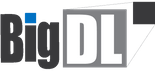

#  Tune forecaster on single node


## Introduction

In this guidance, we demonstrate **how to tune forecaster on single node**. In tuning process, forecaster will find the best hyperparameter combination among user-defined search space, which is a common process if users pursue a forecaster with higher accuracy.

Chronos support forecasting model's hyperparameter tuning in 2 sepaerated APIs (i.e. `Forecaster.tune` and `AutoTSEstimator`) for  users with different demands:

|                         |`Forecaster.tune`|`AutoTSEstimator`|
|-------------------|:---------------:|:---------------:|
|Single Node              |✓                |✓                |
|Cluster                  |X                |✓                |
|Performance-awared Tuning|✓                |X                |
|Feature Selection        |X                |✓                |
|Customized Model         |X                |✓                |

`Forecaster.tune` provides easier and more stright-forward API for users who are familiar with Chronos forecasters, it is recommened to try this method first.

We will take `AutoformerForecaster` and nyc_taxi dataset as an example in this guide.

## Setup

Before we begin, we need to install chronos if it isn’t already available, we choose to use pytorch as deep learning backend.

In [ ]:
!pip install --pre --upgrade bigdl-chronos[pytorch,automl]
!pip uninstall -y torchtext # uninstall torchtext to avoid version conflict
exit()

## Data preparation

First, we load the nyc taxi dataset.

Currently, tune func only support **Numpy Ndarray input**.

In [ ]:
from sklearn.preprocessing import StandardScaler
from bigdl.chronos.data.repo_dataset import get_public_dataset

def get_tsdata():
    name = 'nyc_taxi'
    tsdata_train, tsdata_valid, _ = get_public_dataset(name)
    stand_scaler = StandardScaler()
    for tsdata in [tsdata_train, tsdata_valid]:
        tsdata.impute(mode="linear")\
              .scale(stand_scaler, fit=(tsdata is tsdata_train))
    return tsdata_train, tsdata_valid

tsdata_train, tsdata_valid = get_tsdata()

input_feature_num = 1
output_feature_num = 1
lookback = 20
horizon = 1
label_len = 10

train_data = tsdata_train.roll(lookback=lookback, horizon=horizon, label_len=label_len, time_enc=True).to_numpy()
val_data = tsdata_valid.roll(lookback=lookback, horizon=horizon, label_len=label_len,time_enc=True).to_numpy()

train_data and val_data is compose of (x, y, x_enc, y_enc) as we set `time_enc=True` which is only necessary for Autoformer.

## Tuning

The first step of tuning a forecaster is to define forecaster with space parameters.

There are several common space choices:

`space.Categorical` : search space for hyperparameters which are categorical, e.g. a = space.Categorical('a', 'b', 'c', 'd')

`space.Real` : search space for numeric hyperparameter that takes continuous values, e.g. learning_rate = space.Real(0.01, 0.1, log=True)

`space.Int` : search space for numeric hyperparameter that takes integer values, e.g. range = space.Int(0, 100)

How to change these hyperparameters might be tricky and highly based on experience, but lr, d_model, d_ff and layers or similar parameters usually has a great impact on performance.

In [ ]:
import bigdl.nano.automl.hpo.space as space
from bigdl.chronos.forecaster.autoformer_forecaster import AutoformerForecaster

autoformer = AutoformerForecaster(input_feature_num=input_feature_num,
                                  output_feature_num=output_feature_num,
                                  past_seq_len=lookback,
                                  future_seq_len=horizon,
                                  label_len=label_len,
                                  seed=1024,
                                  freq='t',
                                  loss="mse",
                                  metrics=['mae', 'mse', 'mape'],
                                  lr = space.Real(0.0001, 0.1, log=True),
                                  d_model=space.Categorical(32, 64, 128, 256),
                                  d_ff=space.Categorical(32, 64, 128, 256),
                                  e_layers=space.Categorical(1,2),
                                  n_head=space.Categorical(1,8))

Then just call `tune` on the training data and validation data!

In addition to data, there are three parameters which **need** to be specified : n_trials, target_metric and direction(or directions for multi-objective HPO).

`n_trials`: number of trials to run. The more trials, the longer the running time, the better results.

`target_metric`: the target metric to optimize, a string or an instance of torchmetrics.metric.Metric, default to 'mse'. If you want to try a multi-objective HPO, you need to pass in a list, for example ['mse', 'latency'] in which latency is a built-in metric for performance.

`direction`: in which direction to optimize the target metric, "maximize" or "minimize", default to "minimize". If you want to try a multi-objective HPO, you need to set direction=None, and specify directions which is a list containing direction for each metric, for example ['minimize', 'minimize'].

there are other two parameters which you **may** change their default values : epochs and batch_size.

In [ ]:
autoformer.tune(train_data, validation_data=val_data,
                n_trials=10, target_metric='mse', direction="minimize")

Then, you can see the whole trial history by calling `search_summary()`.

In [ ]:
autoformer.search_summary()

After `tune`, the model parameters of autoformer is **initialized** according to the best trial parameters. You need to fit the model again.

In [ ]:
autoformer.fit(train_data, epochs=4, batch_size=32)
# evaluate on val set
evaluate = autoformer.evaluate(val_data)
print(evaluate)

## Save and load(Optional)

After tuning and fitting, you can save your model by calling `save` with a filename.

In [ ]:
autoformer.save(checkpoint_file="best.ckpt")

Then, when you need to load the model weights, just call `load()` with corresponding filename.

In [ ]:
autoformer.load(checkpoint_file="best.ckpt")

Or if there is a new session, just define a new forecaster with **six necessary parameters: input_feature_num, output_feature_num, past_seq_len, future_seq_len, label_len, and freq**, then `load` with corresponding filename.

In [ ]:
new_autoformer = AutoformerForecaster(input_feature_num=input_feature_num,
                                      output_feature_num=output_feature_num,
                                      past_seq_len=lookback,
                                      future_seq_len=horizon,
                                      label_len=label_len,
                                      freq='s')
new_autoformer.load(checkpoint_file="best.ckpt")